# Exercise 3
**Exploring overfitting in NLP**

When looking at a number of different types of layer for text classification this week you saw many examples of overfitting -- with one of the major reasons for the overfitting being that your training dataset was quite small, and with a small number of words. Embeddings derived from this may be over generalized also. So for this week’s exercise you’re going to train on a large dataset, as well as using transfer learning of an existing set of embeddings.

The dataset is from:  https://www.kaggle.com/kazanova/sentiment140. I’ve cleaned it up a little, in particular to make the file encoding work with Python CSV reader.

The embeddings that you will transfer learn from are called the GloVe, also known as Global Vectors for Word Representation, available at: https://nlp.stanford.edu/projects/glove/

# Imports

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-28 00:16:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   151MB/s    in 1.5s    

2020-08-28 00:16:37 (151 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        l=row[0]
        if l=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [7]:
print(vocab_size)

138839


In [8]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {}

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-08-28 00:16:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   180MB/s    in 1.8s    

2020-08-28 00:16:57 (180 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [9]:
print(len(embeddings_matrix))
print(embeddings_matrix.shape)

138840
(138840, 100)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13884000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,949,153
Trainable params: 65,153
Non-trainable params: 13,884,000
_____________________________________

In [14]:
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 16s - loss: 0.5689 - accuracy: 0.6986 - val_loss: 0.5214 - val_accuracy: 0.7387
Epoch 2/50
4500/4500 - 16s - loss: 0.5288 - accuracy: 0.7304 - val_loss: 0.5112 - val_accuracy: 0.7434
Epoch 3/50
4500/4500 - 15s - loss: 0.5124 - accuracy: 0.7430 - val_loss: 0.5039 - val_accuracy: 0.7532
Epoch 4/50
4500/4500 - 15s - loss: 0.5002 - accuracy: 0.7516 - val_loss: 0.5011 - val_accuracy: 0.7522
Epoch 5/50
4500/4500 - 15s - loss: 0.4935 - accuracy: 0.7558 - val_loss: 0.5069 - val_accuracy: 0.7470
Epoch 6/50
4500/4500 - 16s - loss: 0.4845 - accuracy: 0.7608 - val_loss: 0.5010 - val_accuracy: 0.7527
Epoch 7/50
4500/4500 - 16s - loss: 0.4795 - accuracy: 0.7648 - val_loss: 0.4984 - val_accuracy: 0.7538
Epoch 8/50
4500/4500 - 15s - loss: 0.4739 - accuracy: 0.7677 - val_loss: 0.4981 - val_accuracy: 0.7602
Epoch 9/50
4500/4500 - 15s - loss: 0.4684 - accuracy: 0.7729 - val_loss: 0.4998 - val_accuracy: 0.7566
Epoch 10/50
4500/4500 - 15s - loss: 0.4659 - accuracy: 0.7741 - val_loss:

<Figure size 432x288 with 0 Axes>

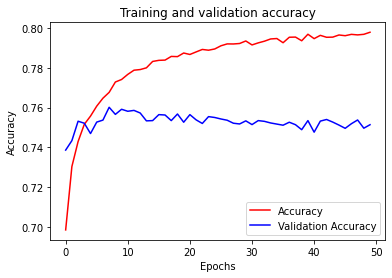

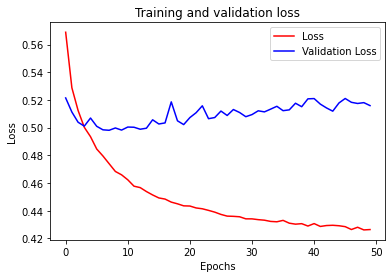

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()